In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

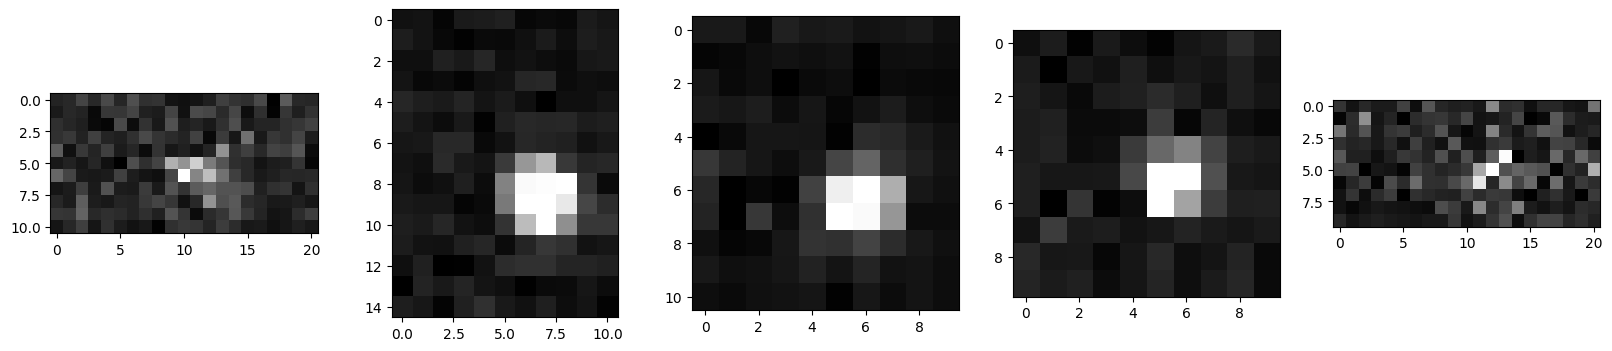

In [2]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

chips_dir = Path("./chips")
idx = 6
bands = ['u', 'g', 'r', 'i', 'z']

imgs = []
for bidx,band in enumerate(bands):
    img = plt.imread(chips_dir / f"{idx}-{band}.jpeg")
    imgs.append(img)
    ax[bidx].imshow(img, cmap='gray')







In [3]:

# lets augment an image chip like we did in the previous notebooks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
test_image = np.ndarray(shape=(1, 64, 64, 1))
test_image_path = "C:/Users/hbar6/projects/MIDS/207/Stellar-Classification/media/single_chip.png"
test_image = load_img(test_image_path, 
                      color_mode='grayscale',
                      target_size=(64,64))
test_image = img_to_array(test_image)



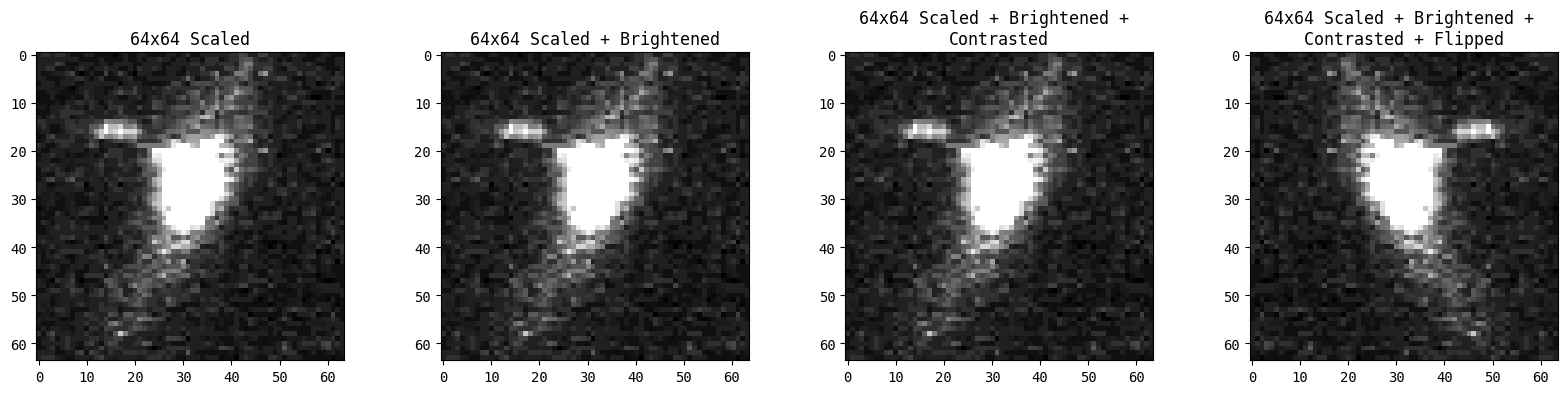

In [4]:
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'monospace',
        'size'   : 10}

matplotlib.rc('font', **font)

brightened_img = tf.image.adjust_brightness(test_image, delta=0.3)
contrasted_img = tf.image.adjust_contrast(brightened_img, contrast_factor=0.3)
flipped_img = tf.image.flip_left_right(contrasted_img)

fig,ax = plt.subplots(1, 4)
fig.set_size_inches(20, 4)
ax[0].set_title("64x64 Scaled")
ax[0].imshow(test_image, cmap='gray')
ax[1].set_title("64x64 Scaled + Brightened")
ax[1].imshow(brightened_img, cmap='gray')
ax[2].set_title("64x64 Scaled + Brightened + \nContrasted")
ax[2].imshow(contrasted_img, cmap='gray')
ax[3].set_title("64x64 Scaled + Brightened + \nContrasted + Flipped")
ax[3].imshow(flipped_img, cmap='gray')

fig.savefig("C:/Users/hbar6/projects/MIDS/207/Stellar-Classification/media/augmented_chip.png", dpi=1000, bbox_inches='tight')

In [5]:
print((brightened_img.numpy() == test_image).all())
print((contrasted_img.numpy() == test_image).all())
print((flipped_img.numpy() == test_image).all())


False
False
False


In [6]:
import pandas as pd
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle 
import astropy.units as u
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval, LogStretch, LinearStretch, SinhStretch, AsinhStretch, make_lupton_rgb
from photutils.segmentation import detect_sources, detect_threshold, SourceFinder, SourceCatalog
from astropy.table import Table

In [7]:
df = pd.read_csv("data/star_classification.csv")


In [8]:
def get_img_plate(row):
    row = row.squeeze()
    bands = ['u', 'g', 'r', 'i', 'z']
    run_id = row['run_ID']
    rerun_id = row['rerun_ID']
    cam_col = row['cam_col']
    field_id = row['field_ID']

    ra = Angle(row['alpha'], u.deg)
    dec = Angle(row['delta'], u.deg)
    c = SkyCoord(ra, dec, frame='icrs')

    xids_table = SDSS.query_region(c)


    xids_table = SDSS.query_region(c) # this can return multiple items
    xids = xids_table.to_pandas()
    xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
    xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
    best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

    best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))
    img_data_buffer = [SDSS.get_images(matches=best_plate, band = band) for band in bands]


    return img_data_buffer

In [9]:
def scale_img(img_data):

  # scale the image so its viewable
  interval = ZScaleInterval(max_iterations=10)
  vmin, vmax = interval.get_limits(img_data)
  norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch(), clip=True)
  img_data = norm(img_data)

  return img_data


n_bands = 1

# lets try the above model on a full frame and see what it classifies

rand_idx = np.random.randint(0, len(df), 1)[0]
# rand_idx = 26688
# rand_idx = 63658
# rand_idx = 45757
rand_idx = 11586


# get a full frame
raw_img_data_buffer = get_img_plate(df.iloc[rand_idx])
img_data_buffer = [scale_img(img_data[0][0].data) for img_data in raw_img_data_buffer]


# pick a band
rand_band_idx = np.random.randint(0, n_bands, 1)[0]
rand_band_idx = 2

scaled_img_data = img_data_buffer[rand_band_idx]


bg_mean, bg_median, bg_std = sigma_clipped_stats(scaled_img_data, sigma=5)
bg_subd_img_data = (scaled_img_data - bg_mean) / bg_std







C:\Users\hbar6\AppData\Local\Temp\ipykernel_43552\2458249976.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)


In [40]:
rand_idx

11586

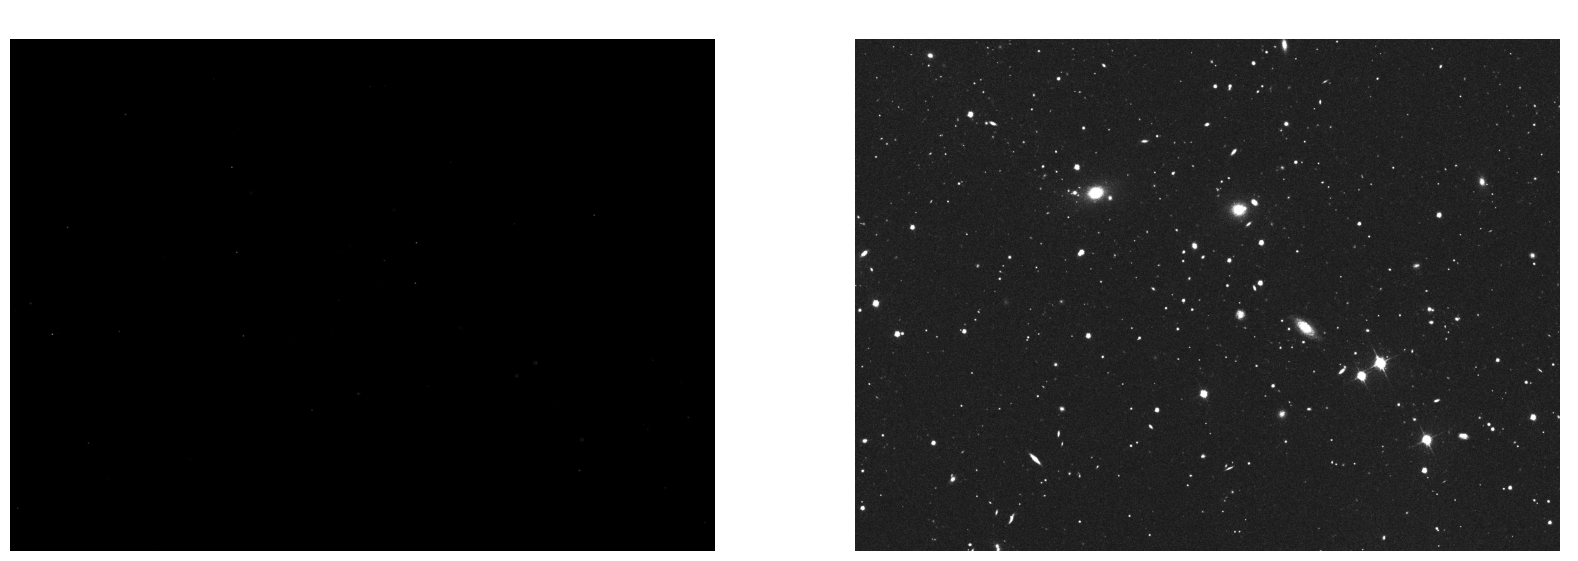

In [22]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,10)
ax[0].imshow(raw_img_data_buffer[rand_band_idx][0][0].data, cmap="gray")
ax[0].set_title("Raw Data", 
                fontdict={
                    'family':'century gothic',
                    'size' : 20,
                    'color' : 'white'
                })
ax[1].imshow(bg_subd_img_data, cmap="gray")
ax[1].set_title("Normalized + Background Subtract + Noise Reduction", 
                fontdict={
                    'family':'century gothic',
                    'size' : 20,
                    'color' : 'white'
                })

ax[0].axis('off')
ax[1].axis('off')

fig.savefig("media/unproc_vs_proc.png", dpi=1000, bbox_inches="tight", transparent=True)